# Find-Lanes-Basic

## Description
This project aims to find lane lines in images similar to what is seen by an autonomous car's front camera. The goal is to draw a reconstructed line on top of the lane lines that we detect.

## Sources

The code in this project is built by following this tutorial on Youtube from ProgrammingKnowledge's channel:
https://www.youtube.com/watch?v=eLTLtUVuuy4&t=3083s

The link to ProgrammingKnowledge's Youtube page:

https://www.youtube.com/channel/UCs6nmQViDpUw0nuIx9c_WvA

## Step 0: Import libraries and image

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

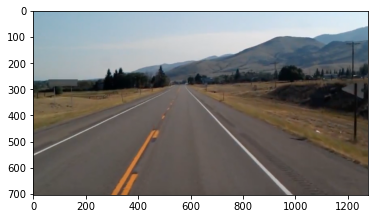

In [2]:
image = cv2.imread('test_image.jpg')

image_show = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_show)
#cv2.imshow('result', image)
#cv2.waitKey(0)

## Step 1: Convert image to grayscale

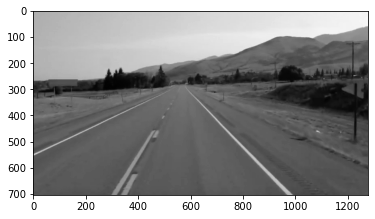

In [3]:
# Make a copy instead of directly assign it to labe_image=image
# so that any changes make in lane_image wont be reflected to image
lane_image = np.copy(image)
gray = cv2.cvtColor(lane_image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')

## Step 2: Gaussian Blur to reduce noise in the image

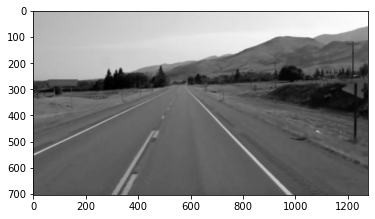

In [4]:
blur = cv2.GaussianBlur(gray, (5,5), 0) # image, kernel_size, deviation
plt.imshow(blur, cmap='gray')

## Step 4: Canny Edge Detection

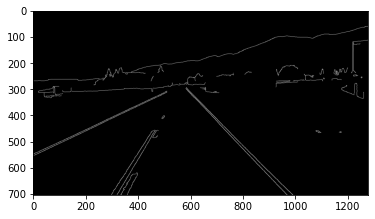

In [5]:
# Perform deritavive in x and y direction, therefore show the gradient

canny = cv2.Canny(blur, 50, 150) # image, low_threshold, high_threshold
plt.imshow(canny, cmap='gray')

## Step 5: Finding Region of Interest

In [6]:
def canny_function(input_image):
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0) # image, kernel_size, deviation
    canny = cv2.Canny(blur, 50, 150) # image, low_threshold, high_threshold
    return canny

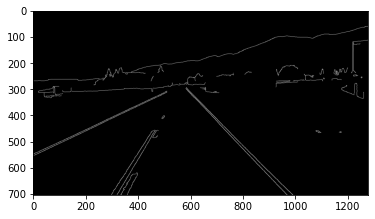

In [7]:
canny = canny_function(lane_image)
plt.imshow(canny, cmap='gray')
# note from the image that the region of interest is a triangle 
# with 3 points located around:
# (200, 700); (1100, 700), (550, 250)

In [8]:
def region_of_interest(input_image):
    height = input_image.shape[0] # get the height of the image, in our case is 700
    triangle = np.array([[(200, height), (1100, height), (550,250)]])
    mask = np.zeros_like(input_image)
    cv2.fillPoly(mask, triangle, 255)
    return mask

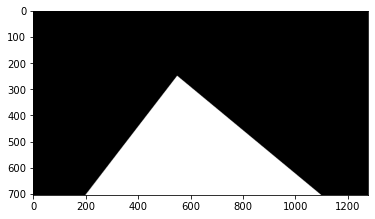

In [9]:
roi_image = region_of_interest(canny)
plt.imshow(roi_image, cmap='gray')

## Step 6: Bitwise& operator

Compare canny image with the roi image. Put zero unless both values are 1.

In [10]:
def bitwise_and_function(input_image):
    height = input_image.shape[0] # get the height of the image, in our case is 700
    triangle = np.array([[(200, height), (1100, height), (550,250)]])
    mask = np.zeros_like(input_image)
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(input_image, mask)
    return masked_image

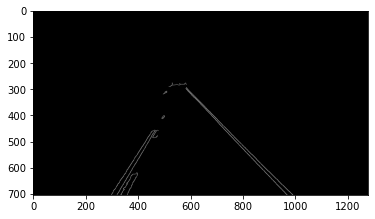

In [11]:
cropped_image = bitwise_and_function(canny)
plt.imshow(cropped_image, cmap='gray')

## Step 7: Hough Lines

In [12]:
# We use hough lines in polar coordinate. 
# Why? to compensate for vertical lines, where gradient is infinite 

In [13]:
# image, rho, theta, number_threshold_point_of_intersection, placeholder_array, minLineLength, maxLineGap
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, minLineLength=40, maxLineGap=5) 

In [14]:
def display_lines(input_image, lines):
    line_image = np.zeros_like(input_image)
    if lines is not None:
        for line in lines:
            #print(line)
            x1,y1,x2,y2 = line.reshape(4)
            cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10)
            
    return line_image

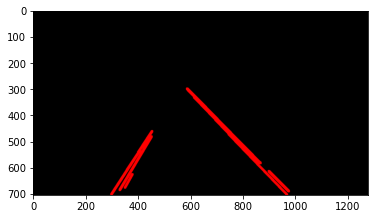

In [15]:
line_image = display_lines(lane_image, lines)
plt.imshow(line_image)

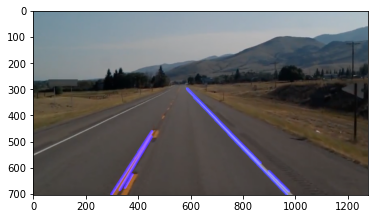

In [16]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
combo_image_show = cv2.cvtColor(combo_image, cv2.COLOR_BGR2RGB)

plt.imshow(combo_image_show)

In [17]:
# Save the image
cv2.imwrite('lined_image.jpg', combo_image)

True

## Step 8: Optimization

In [18]:
def make_coordinates(input_image, line_parameters):
    slope, intercept = line_parameters
    y1 = input_image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope) # y = mx+b, x = (y-b)/m
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

In [19]:
# draw line based on average slope and intercept
def average_slope_intercept(input_image, lines):
    left_fit = []
    right_fit = []
    
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0: # gradient negative belongs to left line (remember that y direction is top-down)
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
            
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)    
    left_line = make_coordinates(input_image, left_fit_average)
    right_line = make_coordinates(input_image, right_fit_average)
            
    return np.array([left_line, right_line])

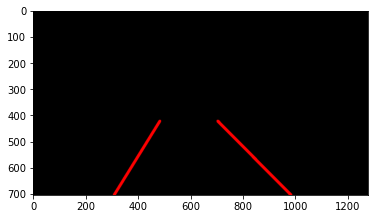

In [20]:
averaged_lines = average_slope_intercept(lane_image, lines)
line_image_optimized = display_lines(lane_image, averaged_lines)
plt.imshow(line_image_optimized)

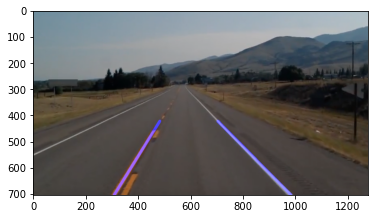

In [21]:
combo_image_optimized = cv2.addWeighted(lane_image, 0.8, line_image_optimized, 1, 1)
combo_image_optimized_show = cv2.cvtColor(combo_image_optimized, cv2.COLOR_BGR2RGB)

plt.imshow(combo_image_optimized_show)

In [22]:
cv2.imwrite('optimized_lane_image.jpg', combo_image_optimized)

True

## Step 9: Detecting lane lines on video

In [23]:
from IPython.display import Video

Video("test2.mp4")

In [30]:
cap = cv2.VideoCapture("test2.mp4")
#output_video = cv2.VideoWriter("output.mp4", -1, 1, (720,1280) )

while(cap.isOpened()):
    _, frame = cap.read()
    canny = canny_function(frame)
    cropped_image = bitwise_and_function(canny)
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, minLineLength=40, maxLineGap=5) 
    averaged_lines = average_slope_intercept(frame, lines)
    line_image_optimized = display_lines(frame, averaged_lines)
    combo_image_optimized = cv2.addWeighted(frame, 0.8, line_image_optimized, 1, 1)
    #output_video.write(combo_image_optimized)
    cv2.imshow('results', combo_image_optimized)
    
    if cv2.waitKey(1) == ord('q'): #press q to escape video
        break

#output_video.release()
cap.release()
cv2.destroyAllWindows()